In [1]:
import numpy as np
import torch

import matplotlib
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
data = torch.load(f"data/cab_data.pt")

Y = data["Y"].detach().numpy()
n = len(Y)
t = np.linspace(1, n, n)

shapley_vals_ks = data["shapley"]["ks"]
shapley_vals_cks = data["shapley"]["cks"]
ks_Y = data["best_Y"]["ks"]
cks_Y = data["best_Y"]["cks"]

ys = np.row_stack([Y, ks_Y, cks_Y])
category = np.array(
    [1 for _ in range(len(Y))]
    + [2 for _ in range(len(ks_Y))]
    + [3 for _ in range(len(cks_Y))]
)
alphas = np.array(
    [0.1 for _ in range(len(Y))]
    + [1 for _ in range(len(ks_Y))]
    + [1 for _ in range(len(cks_Y))]
)
linewidths = np.array(
    [2 for _ in range(len(Y))]
    + [3 for _ in range(len(ks_Y))]
    + [3 for _ in range(len(cks_Y))]
)
ylabels = [fr"$y^{{({i+1})}}$" for i in range(9)]
colors = ["dodgerblue", "crimson", "mediumseagreen"]
title = "CarCabDesign (M=9, D=7)"

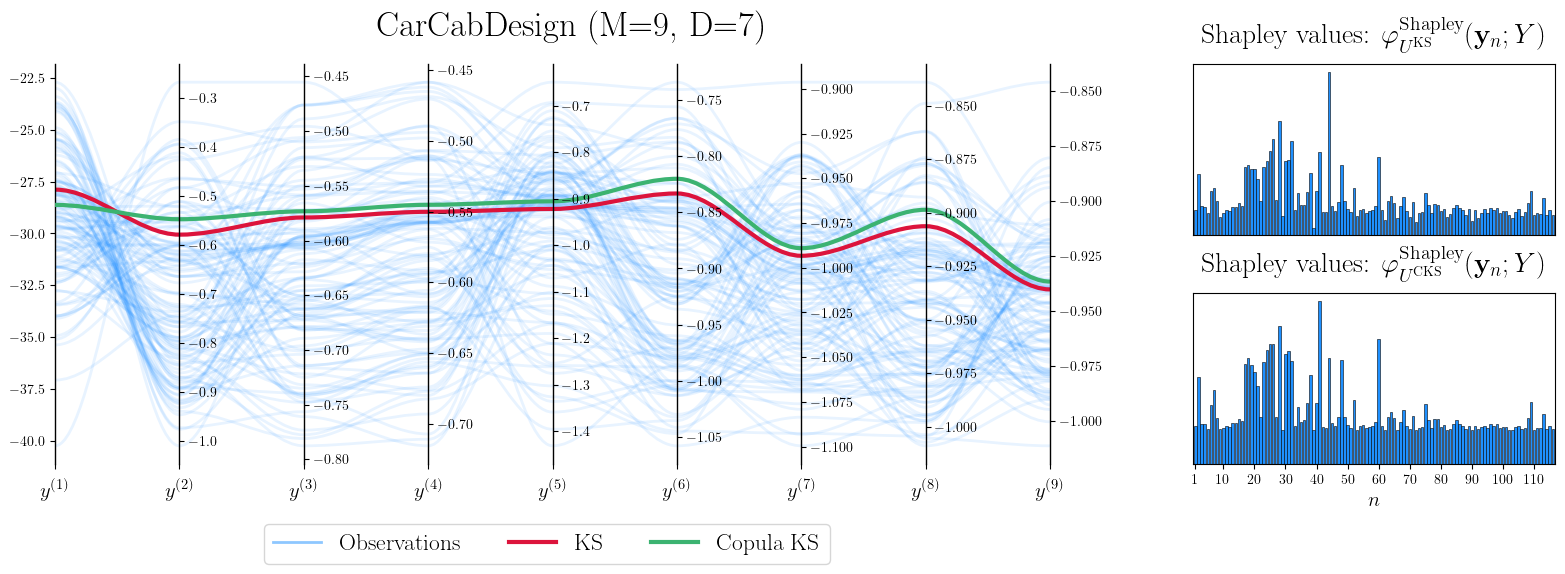

In [3]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.remove()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=1)

gs = fig.add_gridspec(4, 9)
###########################################################################################
main_axes = fig.add_subplot(gs[0:4, 0:6])


ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins

ymins -= dys * 0.05
ymaxs += dys * 0.05

zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

axes = [main_axes] + [main_axes.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    if ax != main_axes:
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("right")
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
    ax.spines["left"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)

main_axes.set_xlim(0, ys.shape[1] - 1)
main_axes.set_xticks(range(ys.shape[1]))
main_axes.set_xticklabels(ylabels, fontsize=15)
main_axes.tick_params(axis="x", which="major", pad=7)
main_axes.spines["right"].set_visible(False)
main_axes.set_title(title, fontsize=25, x=0.52, y=1.05)

for j in range(len(ys)):
    # create bezier curves
    verts = list(
        zip(
            [
                x
                for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)
            ],
            np.repeat(zs[j, :], 3)[1:-1],
        )
    )
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = mpatches.PathPatch(
        path,
        facecolor="none",
        lw=linewidths[j],
        edgecolor=colors[category[j] - 1],
        alpha=alphas[j],
        zorder=category[j],
    )
    main_axes.add_patch(patch)

    
blue_line = mlines.Line2D([], [], color="dodgerblue", linestyle="-", linewidth=2, alpha=0.5)
red_line = mlines.Line2D([], [], color="crimson", linestyle="-", linewidth=3)
green_line = mlines.Line2D([], [], color="mediumseagreen", linestyle="-", linewidth=3)

labels = [
    r"Observations",
    r"KS",
    r"Copula KS",
]

main_axes.legend(
    handles=[
        (blue_line),
        (red_line),
        (green_line),
    ],
    labels=labels,
    ncol=3,
    fontsize=17,
    loc=(0.21, -0.25),
)

###########################################################################################
gs = fig.add_gridspec(4, 8)
axes = fig.add_subplot(gs[0:2, 6:])

axes.bar(t, shapley_vals_ks, color="dodgerblue", edgecolor="k", linewidth=0.4)
axes.set_xlim(0.25, n + 0.75)
axes.set_xticks([])
axes.set_yticks([])
axes.set_title(r"Shapley values: $\varphi^{\textrm{{Shapley}}}_{U^{\textrm{KS}}}(\mathbf{y}_n; Y)$", fontsize=20, pad=15)

axes = fig.add_subplot(gs[2:, 6:])
axes.bar(t, shapley_vals_cks, color="dodgerblue", edgecolor="k", linewidth=0.4)
axes.set_xlim(0.25, n + 0.75)
axes.set_xlabel(r"$n$", fontsize=15)
axes.set_xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], fontsize=10)
axes.set_yticks([])
axes.set_title(r"Shapley values: $\varphi^{\textrm{{Shapley}}}_{U^{\textrm{CKS}}}(\mathbf{y}_n; Y)$", fontsize=20, pad=15) 

plt.show()